In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

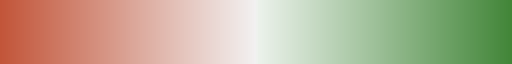

In [3]:
sns.set_theme()
sns.set_style('ticks', {"axes.grid": True})
sns.set_context('talk')
hm_w = 7.5
hm_h = 2.75
set_title = False
my_cmap = sns.diverging_palette(20, 125, as_cmap=True)
my_cmap

In [4]:
my_palette = sns.diverging_palette(20, 125, as_cmap=False)
my_palette

[(0.7634747047461135, 0.3348456555528834, 0.225892295531744),
 (0.8384144678873866, 0.5785740917778832, 0.5129511551488872),
 (0.9140860646530862, 0.8246826885128927, 0.8028133239419791),
 (0.7974936879014439, 0.868249489534432, 0.788438813627399),
 (0.5270994310316574, 0.6954476571009066, 0.5033714796732588),
 (0.25932020565964425, 0.5243170222731213, 0.22106108318482592)]

In [5]:
two_palette = [my_palette[5], my_palette[0]]

In [61]:
systems = ['duckdb', 'umbra']
markers = ['o', '^'] #['d' for _ in range(len(systems))]

In [33]:
def fix_ylim(ax):
    min_y = 1e99
    for col in ax.collections:
        min_y = min(min_y, col.get_offsets()[0][1])
    diff = ax.get_ylim()[0] - min_y
    ax.set_ylim(bottom=diff)

In [34]:
def system_case(s):
    if s == 'duckdb':
        return 'DuckDB'
    elif s == 'umbra':
        return 'Umbra'
    else:
        return s

In [35]:
def collect_randints(systems):
    dfs = []
    for system in systems:
        try:
            df = pd.read_csv(f'../results/{system}/randints/results.csv', header=None, names=['query', 'time'])
            df['system'] = system
            dfs.append(df)
        except:
            None
    result = pd.concat(dfs)
    result.reset_index(inplace=True, drop=True)
    result['system'] = result['system'].apply(lambda s: system_case(s))
    return result

In [36]:
def annotate(ax, systems_and_colors):
    systems = [s for (s, c) in systems_and_colors]
    colors = [c for (s, c) in systems_and_colors]
    for coll, s, c in zip(ax.collections, systems, colors):
        of = coll.get_offsets()[-1]
        label_of = (ax.get_xlim()[1], of[1] - ax.get_ylim()[1] * 0.02)
        ax.annotate(s, label_of, c=c)

In [37]:
randints_df = collect_randints(systems)

asc_desc_df = randints_df[(randints_df['query'] == '100_asc') | (randints_df['query'] == '100_desc') | (randints_df['query'] == '100')]
asc_desc_df = asc_desc_df.groupby(['system', 'query']).median().reset_index().sort_values('system')

randints_df = randints_df[(randints_df['query'] != '100_asc') & (randints_df['query'] != '100_desc')]
randints_df['query'] = pd.to_numeric(randints_df['query'])
randints_df['query'] = randints_df['query']
randints_df = randints_df.groupby(['system', 'query']).median().reset_index().sort_values('system')

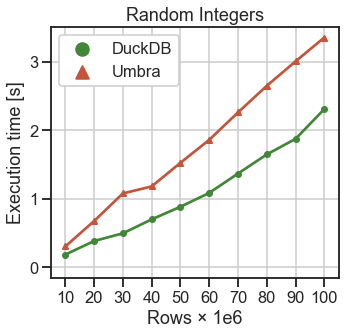

In [66]:
with plt.rc_context({'lines.linewidth': 1.5}):
    plot = sns.catplot(data=randints_df, kind='point', markers=markers, x='query', y='time', hue='system',
                       facet_kws=dict(despine=False), palette=two_palette, height=5, aspect=0.75)
plt.xlabel('Rows × 1e6')
plt.ylabel('Execution time [s]')

ax = plot.axes[0][0]
ax.grid(True)
fix_ylim(ax)
for col in ax.collections:
    col.set_sizes([25])
ax.set_title('Random Integers')

plot._legend.set_visible(False)
with plt.rc_context({'legend.markerscale': 2.5}):
    lgnd = ax.legend(framealpha=1)

plt.tight_layout()
plt.savefig('figs_vldb/randints.eps', bbox_inches="tight")

In [42]:
sfs = [100, 300]

In [43]:
def collect_tpcds_customer(systems, sfs):
    dfs = []
    for system in systems:
        for sf in sfs:
            try:
                df = pd.read_csv(f'../results/{system}/tpcds/sf{sf}/customer/results.csv', header=None, names=['query', 'time'])
                df['system'] = system
                df['sf'] = sf
                dfs.append(df)
            except:
                None
    result = pd.concat(dfs)
    result.reset_index(inplace=True, drop=True)
    result['system'] = result['system'].apply(lambda s: system_case(s))
    return result

In [44]:
customer_df = collect_tpcds_customer(systems, sfs)

customer_payload_df = customer_df[customer_df['query'].str.contains('payload')]
customer_sort_df = customer_df[customer_df['query'].str.contains('sort')]
customer_df = customer_df[~customer_df['query'].str.contains('payload')]
customer_df = customer_df[~customer_df['query'].str.contains('sort')]

customer_int_df = customer_df[customer_df['query'].str.contains('int')].reset_index(drop=True)
customer_int_df['query'] = customer_int_df['query'].apply(lambda q: q.replace('int', ''))
customer_int_df['query'] = pd.to_numeric(customer_int_df['query'])
customer_int_df = customer_int_df.groupby(['system', 'query', 'sf']).median().reset_index().sort_values('system')

customer_varchar_df = customer_df[customer_df['query'].str.contains('varchar')].reset_index(drop=True)
customer_varchar_df['query'] = customer_varchar_df['query'].apply(lambda q: q.replace('varchar', ''))
customer_varchar_df['query'] = pd.to_numeric(customer_varchar_df['query'])
customer_varchar_df = customer_varchar_df.groupby(['system', 'query', 'sf']).median().reset_index().sort_values('system')

customer_payload_df['query'] = customer_payload_df['query'].apply(lambda q: q.replace('_payload', ''))
customer_payload_df['payload'] = customer_payload_df['query'].apply(lambda q: 'int' if 'int' in q else 'varchar')
customer_payload_df['query'] = customer_payload_df['query'].apply(lambda q: q.replace('int', ''))
customer_payload_df['query'] = customer_payload_df['query'].apply(lambda q: q.replace('varchar', ''))
customer_payload_df['query'] = pd.to_numeric(customer_payload_df['query'])
customer_payload_df = customer_payload_df.groupby(['system', 'query', 'sf', 'payload']).median().reset_index().sort_values('system')
customer_int_payload_df = customer_payload_df[customer_payload_df['payload'] == 'int']
customer_varchar_payload_df = customer_payload_df[customer_payload_df['payload'] == 'varchar']

customer_sort_df['query'] = customer_sort_df['query'].apply(lambda q: q.replace('sort_', ''))
customer_sort_df['query'] = customer_sort_df['query'].apply(lambda q: 'integer' if q == 'ints' else 'string')
customer_sort_df = customer_sort_df.groupby(['system', 'query', 'sf']).median().reset_index().sort_values('system')

In [45]:
customer_payload_df = customer_payload_df[(customer_payload_df['payload'] == 'int') & (customer_payload_df['query'] == 10) | (customer_payload_df['payload'] == 'varchar') & (customer_payload_df['query'] == 8)]
customer_payload_df = customer_payload_df.sort_values(['system', 'payload'])
customer_payload_df['payload'] = customer_payload_df['payload'].apply(lambda q: 'integer' if q == 'int' else 'string')

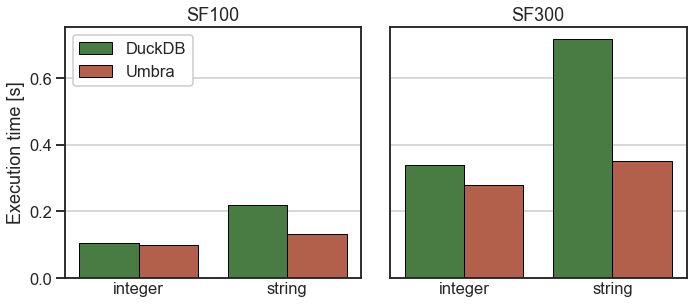

In [46]:
kwargs = {'linewidth': 1, 'edgecolor': 'black'}
plot = sns.catplot(data=customer_payload_df, col='sf', kind='bar', x='payload', y='time', hue='system',
                   sharey=True, sharex=False, col_wrap=2, palette=two_palette, facet_kws=dict(despine=False),
                   **kwargs)

for i, ax in enumerate(plot.axes):
    if i == 0:
        ax.set_ylabel('Execution time [s]')
        ax.set_title('SF100')
    else:
        ax.set_title('SF300')
        ax.tick_params(axis='y', which='major', length=0)
    ax.tick_params(axis='x', which='major', length=0)
    ax.set_xlabel('')

plot._legend.set_visible(False)
handles, labels = plot.axes[0].get_legend_handles_labels()
lgnd = plot.axes[0].legend(handles=handles, labels=labels, frameon=True, loc='upper left', framealpha=1)

plt.savefig('figs_vldb/payload_type.eps', bbox_inches="tight")

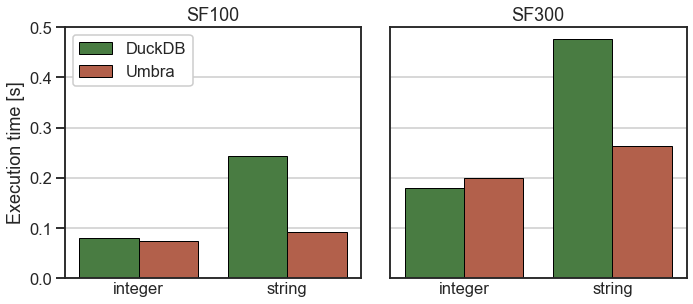

In [47]:
customer_sort_df['system'] = customer_sort_df['system'].apply(lambda s: 'CH' if s == 'ClickHouse' else s)
kwargs = {'linewidth': 1, 'edgecolor': 'black'}
plot = sns.catplot(data=customer_sort_df, col='sf', kind='bar', x='query', y='time', hue='system',
                   sharey=True, sharex=False, col_wrap=2, palette=two_palette, facet_kws=dict(despine=False),
                   **kwargs)

for i, ax in enumerate(plot.axes):
    if i == 0:
        ax.set_ylabel('Execution time [s]')
        ax.set_title('SF100')
    else:
        ax.set_title('SF300')
        ax.tick_params(axis='y', which='major', length=0)
    ax.tick_params(axis='x', which='major', length=0)
    ax.set_xlabel('')

plot._legend.set_visible(False)
handles, labels = plot.axes[0].get_legend_handles_labels()
lgnd = plot.axes[0].legend(handles=handles, labels=labels, frameon=True, loc='upper left', framealpha=1)

plt.savefig('figs_vldb/key_type.eps', bbox_inches="tight")

In [48]:
sfs = [10, 100]

In [49]:
def collect_tpcds_catalog_sales(systems, sfs):
    dfs = []
    for system in systems:
        for sf in sfs:
            try:
                df = pd.read_csv(f'../results/{system}/tpcds/sf{sf}/catalog_sales/results.csv', header=None, names=['query', 'time'])
                df['system'] = system
                df['sf'] = sf
                dfs.append(df)
            except:
                None
    result = pd.concat(dfs)
    result.reset_index(inplace=True, drop=True)
    result['system'] = result['system'].apply(lambda s: system_case(s))
    return result

In [50]:
catalog_sales_df = collect_tpcds_catalog_sales(systems, sfs)

catalog_sales_payload_df = catalog_sales_df[catalog_sales_df['query'].str.contains('payload')].reset_index(drop=True)
catalog_sales_payload_df['query'] = catalog_sales_payload_df['query'].apply(lambda q: q.replace('payload', ''))
catalog_sales_payload_df['query'] = pd.to_numeric(catalog_sales_payload_df['query'])
catalog_sales_payload_df = catalog_sales_payload_df.groupby(['system', 'query', 'sf']).median().reset_index().sort_values('system')

catalog_sales_sorting_df = catalog_sales_df[catalog_sales_df['query'].str.contains('sorting')].reset_index(drop=True)
catalog_sales_sorting_df['query'] = catalog_sales_sorting_df['query'].apply(lambda q: q.replace('sorting', ''))
catalog_sales_sorting_df['query'] = pd.to_numeric(catalog_sales_sorting_df['query'])
catalog_sales_sorting_df = catalog_sales_sorting_df.groupby(['system', 'query', 'sf']).median().reset_index().sort_values('system')

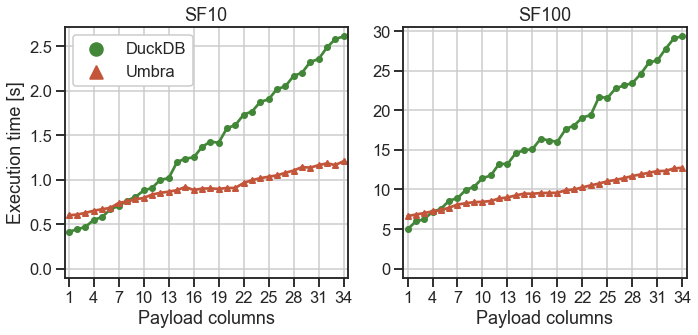

In [64]:
with plt.rc_context({'lines.linewidth': 1.5}):
    plot = sns.catplot(data=catalog_sales_payload_df, col='sf', kind='point', markers=markers, x='query', y='time',
                       hue='system', sharey=False, sharex=True, col_wrap=2,
                       palette=two_palette, facet_kws=dict(despine=False))

for i, ax in enumerate(plot.axes):
    ax.set_ylabel('Execution time [s]')
    
    fix_ylim(ax)
    if i == 0:
        ax.set_title('SF10')
    else:
        ax.set_title('SF100')
        ax.set_ylabel('')
    ax.set_xlabel('Payload columns')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    ax.grid(True)
    for col in ax.collections:
        col.set_sizes([25])

for lh in plot._legend.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]
    
plot._legend.set_visible(False)
handles, labels = plot.axes[0].get_legend_handles_labels()

with plt.rc_context({'legend.markerscale': 2.5}):
    lgnd = plot.axes[0].legend(handles=handles, labels=labels, frameon=True, framealpha=1)

# plt.tight_layout()
plt.savefig('figs_vldb/catalog_sales.eps', bbox_inches="tight")